# Deep Neural Network for Image Classification

In [1]:
#Packages

import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import imageio
from PIL import Image
from scipy import misc

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
# Required functions

def sigmoid(Z):
   
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):

    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
 
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
  
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def initialize_parameters(n_x, n_h, n_y):

    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters     


def initialize_parameters_deep(layer_dims):
   
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) 
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

def linear_forward(A, W, b):

    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                 
    
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

def compute_cost(AL, Y):

    m = Y.shape[1]

    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

def linear_backward(dZ, cache):
 
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
  
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    
    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def predict(X, y, parameters):
 
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p):
   
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) 
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

In [5]:
def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [6]:
#Loading the dataset
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


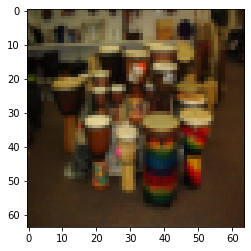

In [7]:
# Example of a picture
index = 5
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [8]:
#Exploring the dataset

m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [9]:
#Reshaping
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

#Standardizing
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [10]:
#CONSTANTS for 2-layer model

n_x = 12288  # num_px*num_px*3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [11]:
# Two layer neural network

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
 
    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation:
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')
       
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Cost after every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # Plot of the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6930497356599888
Cost after iteration 1: 0.6926114346158595
Cost after iteration 2: 0.6921772249299877
Cost after iteration 3: 0.6917552969254053
Cost after iteration 4: 0.6913435039192125
Cost after iteration 5: 0.6909413076936088
Cost after iteration 6: 0.6905374978216906
Cost after iteration 7: 0.6901226460083468
Cost after iteration 8: 0.6896996461490383
Cost after iteration 9: 0.6892649194044295
Cost after iteration 10: 0.6888180223157058
Cost after iteration 11: 0.688354486332672
Cost after iteration 12: 0.6878723543793064
Cost after iteration 13: 0.6873715141970556
Cost after iteration 14: 0.6868477883672163
Cost after iteration 15: 0.6862993037700852
Cost after iteration 16: 0.6857278097649127
Cost after iteration 17: 0.6851299105519605
Cost after iteration 18: 0.6845041875313205
Cost after iteration 19: 0.6838513822703769
Cost after iteration 20: 0.6831687021908813
Cost after iteration 21: 0.6824544844489573
Cost after iteration 22: 0.6817078582534386

Cost after iteration 187: 0.6350647455797453
Cost after iteration 188: 0.6348792368999359
Cost after iteration 189: 0.6346919826220717
Cost after iteration 190: 0.6345030186485225
Cost after iteration 191: 0.6343123039288525
Cost after iteration 192: 0.6341198066005215
Cost after iteration 193: 0.6339255242138426
Cost after iteration 194: 0.6337294397059459
Cost after iteration 195: 0.633531541715651
Cost after iteration 196: 0.6333317865742331
Cost after iteration 197: 0.6331301800392117
Cost after iteration 198: 0.6329267017700396
Cost after iteration 199: 0.6327213252763717
Cost after iteration 200: 0.6325140647912677
Cost after iteration 201: 0.6323048674546923
Cost after iteration 202: 0.63209373611034
Cost after iteration 203: 0.631880641381193
Cost after iteration 204: 0.6316655721211785
Cost after iteration 205: 0.631448569800789
Cost after iteration 206: 0.6312295857129986
Cost after iteration 207: 0.6310076238614161
Cost after iteration 208: 0.6307820790719426
Cost after iter

Cost after iteration 371: 0.5727301965840434
Cost after iteration 372: 0.5722958449036031
Cost after iteration 373: 0.5718587934338277
Cost after iteration 374: 0.5714347673669701
Cost after iteration 375: 0.5709969152560679
Cost after iteration 376: 0.5705652923334497
Cost after iteration 377: 0.570134122989867
Cost after iteration 378: 0.5697023111250547
Cost after iteration 379: 0.569284423055604
Cost after iteration 380: 0.5688610237055228
Cost after iteration 381: 0.5684302517100032
Cost after iteration 382: 0.5680073866870102
Cost after iteration 383: 0.5675798502331278
Cost after iteration 384: 0.5671511302939478
Cost after iteration 385: 0.5667246534469208
Cost after iteration 386: 0.5662932141024432
Cost after iteration 387: 0.5658616785183965
Cost after iteration 388: 0.5654314160595252
Cost after iteration 389: 0.5649994248298092
Cost after iteration 390: 0.5645670397759914
Cost after iteration 391: 0.5641319313592159
Cost after iteration 392: 0.5636977860773337
Cost after i

Cost after iteration 556: 0.49084159839251473
Cost after iteration 557: 0.4905063175791277
Cost after iteration 558: 0.4899981738393679
Cost after iteration 559: 0.4896627830148713
Cost after iteration 560: 0.4891312630249197
Cost after iteration 561: 0.4889390898767669
Cost after iteration 562: 0.48842544612100014
Cost after iteration 563: 0.48825802784974887
Cost after iteration 564: 0.4877808888685003
Cost after iteration 565: 0.48842176614690896
Cost after iteration 566: 0.48775993745998275
Cost after iteration 567: 0.48739921691393445
Cost after iteration 568: 0.4876332174852819
Cost after iteration 569: 0.4877183458009773
Cost after iteration 570: 0.48674240492252335
Cost after iteration 571: 0.48582316994828645
Cost after iteration 572: 0.48643825884213954
Cost after iteration 573: 0.4861698717068315
Cost after iteration 574: 0.4854641306785505
Cost after iteration 575: 0.48543143916027814
Cost after iteration 576: 0.48404130299116116
Cost after iteration 577: 0.4840970009104865

Cost after iteration 737: 0.4072267308241492
Cost after iteration 738: 0.40932804888730506
Cost after iteration 739: 0.40603365207407566
Cost after iteration 740: 0.4077982751380309
Cost after iteration 741: 0.4048974330135651
Cost after iteration 742: 0.406021376088833
Cost after iteration 743: 0.402999109447915
Cost after iteration 744: 0.40486407143887926
Cost after iteration 745: 0.40251025496958465
Cost after iteration 746: 0.40577786775374214
Cost after iteration 747: 0.4027207069851463
Cost after iteration 748: 0.40560148459525985
Cost after iteration 749: 0.4020176441893281
Cost after iteration 750: 0.4049995220756134
Cost after iteration 751: 0.4018773332836805
Cost after iteration 752: 0.4048808500710187
Cost after iteration 753: 0.40101060896143426
Cost after iteration 754: 0.4058752519951181
Cost after iteration 755: 0.4006995430692225
Cost after iteration 756: 0.40324609011776524
Cost after iteration 757: 0.39884305359305666
Cost after iteration 758: 0.40125764337933834
Co

Cost after iteration 919: 0.3755307037164059
Cost after iteration 920: 0.38391262024200357
Cost after iteration 921: 0.36405021747795047
Cost after iteration 922: 0.3767628073743036
Cost after iteration 923: 0.3739545936093726
Cost after iteration 924: 0.3822615030093202
Cost after iteration 925: 0.3631215396328314
Cost after iteration 926: 0.3742616515907946
Cost after iteration 927: 0.37008322002804117
Cost after iteration 928: 0.3805904238513916
Cost after iteration 929: 0.36465989110285635
Cost after iteration 930: 0.3779314259416655
Cost after iteration 931: 0.37411621155040514
Cost after iteration 932: 0.38113471929747583
Cost after iteration 933: 0.3610984200794643
Cost after iteration 934: 0.370401857554439
Cost after iteration 935: 0.3664013062554125
Cost after iteration 936: 0.37686802762692284
Cost after iteration 937: 0.3630084979508557
Cost after iteration 938: 0.3751623702171876
Cost after iteration 939: 0.3692105703199125
Cost after iteration 940: 0.3780644957561527
Cost

Cost after iteration 1098: 0.3064136390326719
Cost after iteration 1099: 0.3060474672601299
Cost after iteration 1100: 0.3052753636196267
Cost after iteration 1101: 0.30384788273387336
Cost after iteration 1102: 0.30340984949425615
Cost after iteration 1103: 0.3027732277353154
Cost after iteration 1104: 0.30152598304884015
Cost after iteration 1105: 0.301249571244554
Cost after iteration 1106: 0.3004249709977333
Cost after iteration 1107: 0.2983190609250531
Cost after iteration 1108: 0.29658667784874804
Cost after iteration 1109: 0.29627827413822616
Cost after iteration 1110: 0.2920973978152587
Cost after iteration 1111: 0.29040658131417996
Cost after iteration 1112: 0.29251056548626464
Cost after iteration 1113: 0.2894955838110648
Cost after iteration 1114: 0.291772122330576
Cost after iteration 1115: 0.28886402262289046
Cost after iteration 1116: 0.2904514710905319
Cost after iteration 1117: 0.28779366554060076
Cost after iteration 1118: 0.2895580914263654
Cost after iteration 1119: 

Cost after iteration 1278: 0.22376909969084308
Cost after iteration 1279: 0.22912446205463516
Cost after iteration 1280: 0.23320057584352982
Cost after iteration 1281: 0.23870108182341265
Cost after iteration 1282: 0.23002665721148435
Cost after iteration 1283: 0.23904915346187722
Cost after iteration 1284: 0.23111360336945203
Cost after iteration 1285: 0.23913885231697848
Cost after iteration 1286: 0.23123932158508662
Cost after iteration 1287: 0.24134510103176487
Cost after iteration 1288: 0.23385249023001958
Cost after iteration 1289: 0.2406240670835111
Cost after iteration 1290: 0.23333563192514398
Cost after iteration 1291: 0.24365517454603058
Cost after iteration 1292: 0.23596408147190986
Cost after iteration 1293: 0.2443275024901376
Cost after iteration 1294: 0.23668917335229062
Cost after iteration 1295: 0.2498383980506842
Cost after iteration 1296: 0.24084710163950768
Cost after iteration 1297: 0.24736526751858018
Cost after iteration 1298: 0.2403197111201207
Cost after iterat

Cost after iteration 1456: 0.1829413062873612
Cost after iteration 1457: 0.18606904241764108
Cost after iteration 1458: 0.18486779474449733
Cost after iteration 1459: 0.18745902435313924
Cost after iteration 1460: 0.18626242549806743
Cost after iteration 1461: 0.1914592247746058
Cost after iteration 1462: 0.18211460345569183
Cost after iteration 1463: 0.18651287260404
Cost after iteration 1464: 0.18569325018498498
Cost after iteration 1465: 0.18768581813660082
Cost after iteration 1466: 0.17891038983524216
Cost after iteration 1467: 0.18536550904360638
Cost after iteration 1468: 0.18523906372727492
Cost after iteration 1469: 0.18795117409798276
Cost after iteration 1470: 0.17906744933987098
Cost after iteration 1471: 0.188896155334373
Cost after iteration 1472: 0.1888366541763002
Cost after iteration 1473: 0.1926373963689251
Cost after iteration 1474: 0.18308725798870956
Cost after iteration 1475: 0.19055100399174124
Cost after iteration 1476: 0.18126315505429405
Cost after iteration 1

Cost after iteration 1631: 0.12176370532324018
Cost after iteration 1632: 0.12133936131060266
Cost after iteration 1633: 0.12113536347927768
Cost after iteration 1634: 0.12087324740531354
Cost after iteration 1635: 0.12113408183091215
Cost after iteration 1636: 0.12095609173609752
Cost after iteration 1637: 0.12106015998910502
Cost after iteration 1638: 0.12088354094764127
Cost after iteration 1639: 0.12134543985004549
Cost after iteration 1640: 0.12088045670817404
Cost after iteration 1641: 0.1207158569458964
Cost after iteration 1642: 0.12048929336872896
Cost after iteration 1643: 0.12089642859782337
Cost after iteration 1644: 0.12041488485048776
Cost after iteration 1645: 0.12020344477675436
Cost after iteration 1646: 0.11997593257525205
Cost after iteration 1647: 0.12039550005867909
Cost after iteration 1648: 0.11995276613833042
Cost after iteration 1649: 0.12005859857819874
Cost after iteration 1650: 0.11966732163939019
Cost after iteration 1651: 0.12049597930094158
Cost after ite

Cost after iteration 1807: 0.09492686887181795
Cost after iteration 1808: 0.09472591623193082
Cost after iteration 1809: 0.09489383336679631
Cost after iteration 1810: 0.09439879460855934
Cost after iteration 1811: 0.09411375871444116
Cost after iteration 1812: 0.09389854874608862
Cost after iteration 1813: 0.09402963347481584
Cost after iteration 1814: 0.09348670843767201
Cost after iteration 1815: 0.0931158244498296
Cost after iteration 1816: 0.09265817560458889
Cost after iteration 1817: 0.09273651324482257
Cost after iteration 1818: 0.0922939742180594
Cost after iteration 1819: 0.09222175023512193
Cost after iteration 1820: 0.09187281355173364
Cost after iteration 1821: 0.09195022437928076
Cost after iteration 1822: 0.09157868019579785
Cost after iteration 1823: 0.09146961531594407
Cost after iteration 1824: 0.09142669216647978
Cost after iteration 1825: 0.09152996813340972
Cost after iteration 1826: 0.09117088283586648
Cost after iteration 1827: 0.09125338578466627
Cost after iter

Cost after iteration 1983: 0.07555079821038752
Cost after iteration 1984: 0.07536077071726685
Cost after iteration 1985: 0.07537342241339628
Cost after iteration 1986: 0.07514332040331861
Cost after iteration 1987: 0.07511632077830138
Cost after iteration 1988: 0.07494332307460784
Cost after iteration 1989: 0.07496246602321792
Cost after iteration 1990: 0.07476088690591885
Cost after iteration 1991: 0.07477913127770652
Cost after iteration 1992: 0.07464039350218281
Cost after iteration 1993: 0.0747630921506799
Cost after iteration 1994: 0.07466975460554161
Cost after iteration 1995: 0.0748302318226607
Cost after iteration 1996: 0.07464738061959614
Cost after iteration 1997: 0.07485532890354535
Cost after iteration 1998: 0.07455470245436681
Cost after iteration 1999: 0.07458506999166614
Cost after iteration 2000: 0.07439078704319091
Cost after iteration 2001: 0.07458071711003715
Cost after iteration 2002: 0.07424951873667504
Cost after iteration 2003: 0.07426586355114641
Cost after iter

Cost after iteration 2160: 0.06205802763016747
Cost after iteration 2161: 0.06196582858213851
Cost after iteration 2162: 0.061904560204569234
Cost after iteration 2163: 0.06194634715731617
Cost after iteration 2164: 0.061785921780237445
Cost after iteration 2165: 0.06169164773563017
Cost after iteration 2166: 0.06164113335559774
Cost after iteration 2167: 0.06167947178915248
Cost after iteration 2168: 0.06152118104607518
Cost after iteration 2169: 0.06142196098755113
Cost after iteration 2170: 0.061334730318369515
Cost after iteration 2171: 0.061366945775607154
Cost after iteration 2172: 0.061236898934449925
Cost after iteration 2173: 0.06114283183539316
Cost after iteration 2174: 0.06106778083897898
Cost after iteration 2175: 0.06112243165105401
Cost after iteration 2176: 0.060976753307140245
Cost after iteration 2177: 0.06088884894653315
Cost after iteration 2178: 0.0607735736781444
Cost after iteration 2179: 0.060714145769373756
Cost after iteration 2180: 0.060579308561281506
Cost a

Cost after iteration 2337: 0.051440497961911885
Cost after iteration 2338: 0.05139001780378795
Cost after iteration 2339: 0.05132903780113553
Cost after iteration 2340: 0.051282058824673224
Cost after iteration 2341: 0.05123486441573471
Cost after iteration 2342: 0.051186689574222594
Cost after iteration 2343: 0.05113757240026145
Cost after iteration 2344: 0.051089590752177644
Cost after iteration 2345: 0.05105109591859052
Cost after iteration 2346: 0.05103745500428569
Cost after iteration 2347: 0.05104347618117022
Cost after iteration 2348: 0.05100351944283487
Cost after iteration 2349: 0.05102128047866068
Cost after iteration 2350: 0.05096490110340814
Cost after iteration 2351: 0.050948693653113115
Cost after iteration 2352: 0.0508811283223623
Cost after iteration 2353: 0.05084510473599217
Cost after iteration 2354: 0.050786872583686415
Cost after iteration 2355: 0.05080322568330168
Cost after iteration 2356: 0.0506894128251202
Cost after iteration 2357: 0.05061333806620412
Cost afte

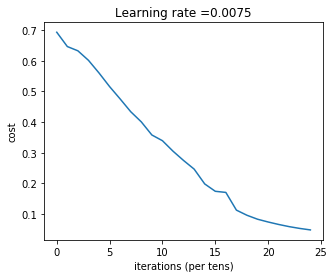

In [12]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [13]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [14]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


In [15]:
#CONSTANTS for L-layer model
layers_dims = [12288, 20, 7, 5, 1]

In [16]:
# L-layer neural network

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009

    np.random.seed(1)
    costs = []
    
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation:
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost
        cost = compute_cost(AL, Y)
    
        # Backward propagation
        grads =  L_model_backward(AL, Y, caches)
 
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
                
        #Cost after every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # Plot of the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


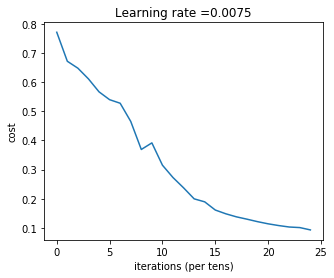

In [17]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [18]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [19]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


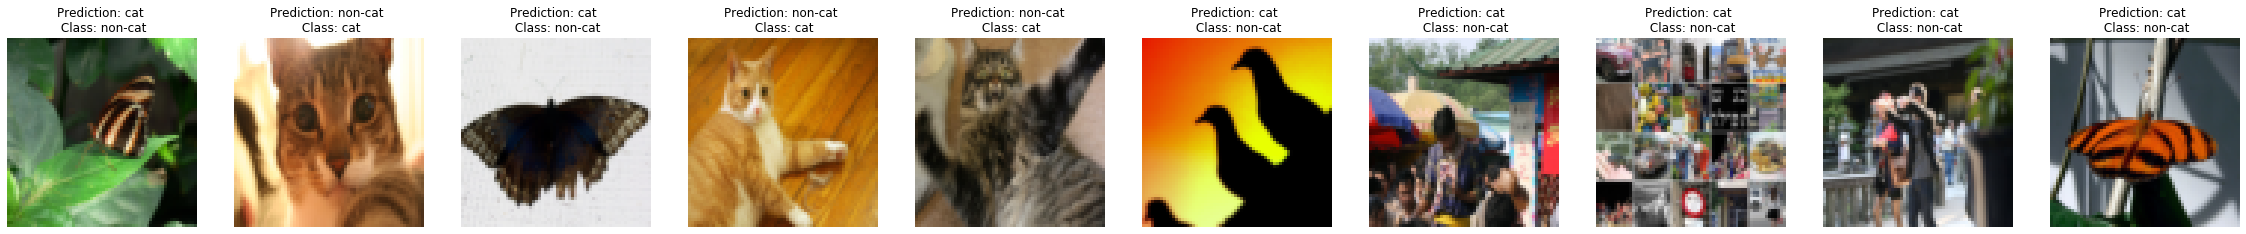

In [20]:
#Some mislabeled images
print_mislabeled_images(classes, test_x, test_y, pred_test)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


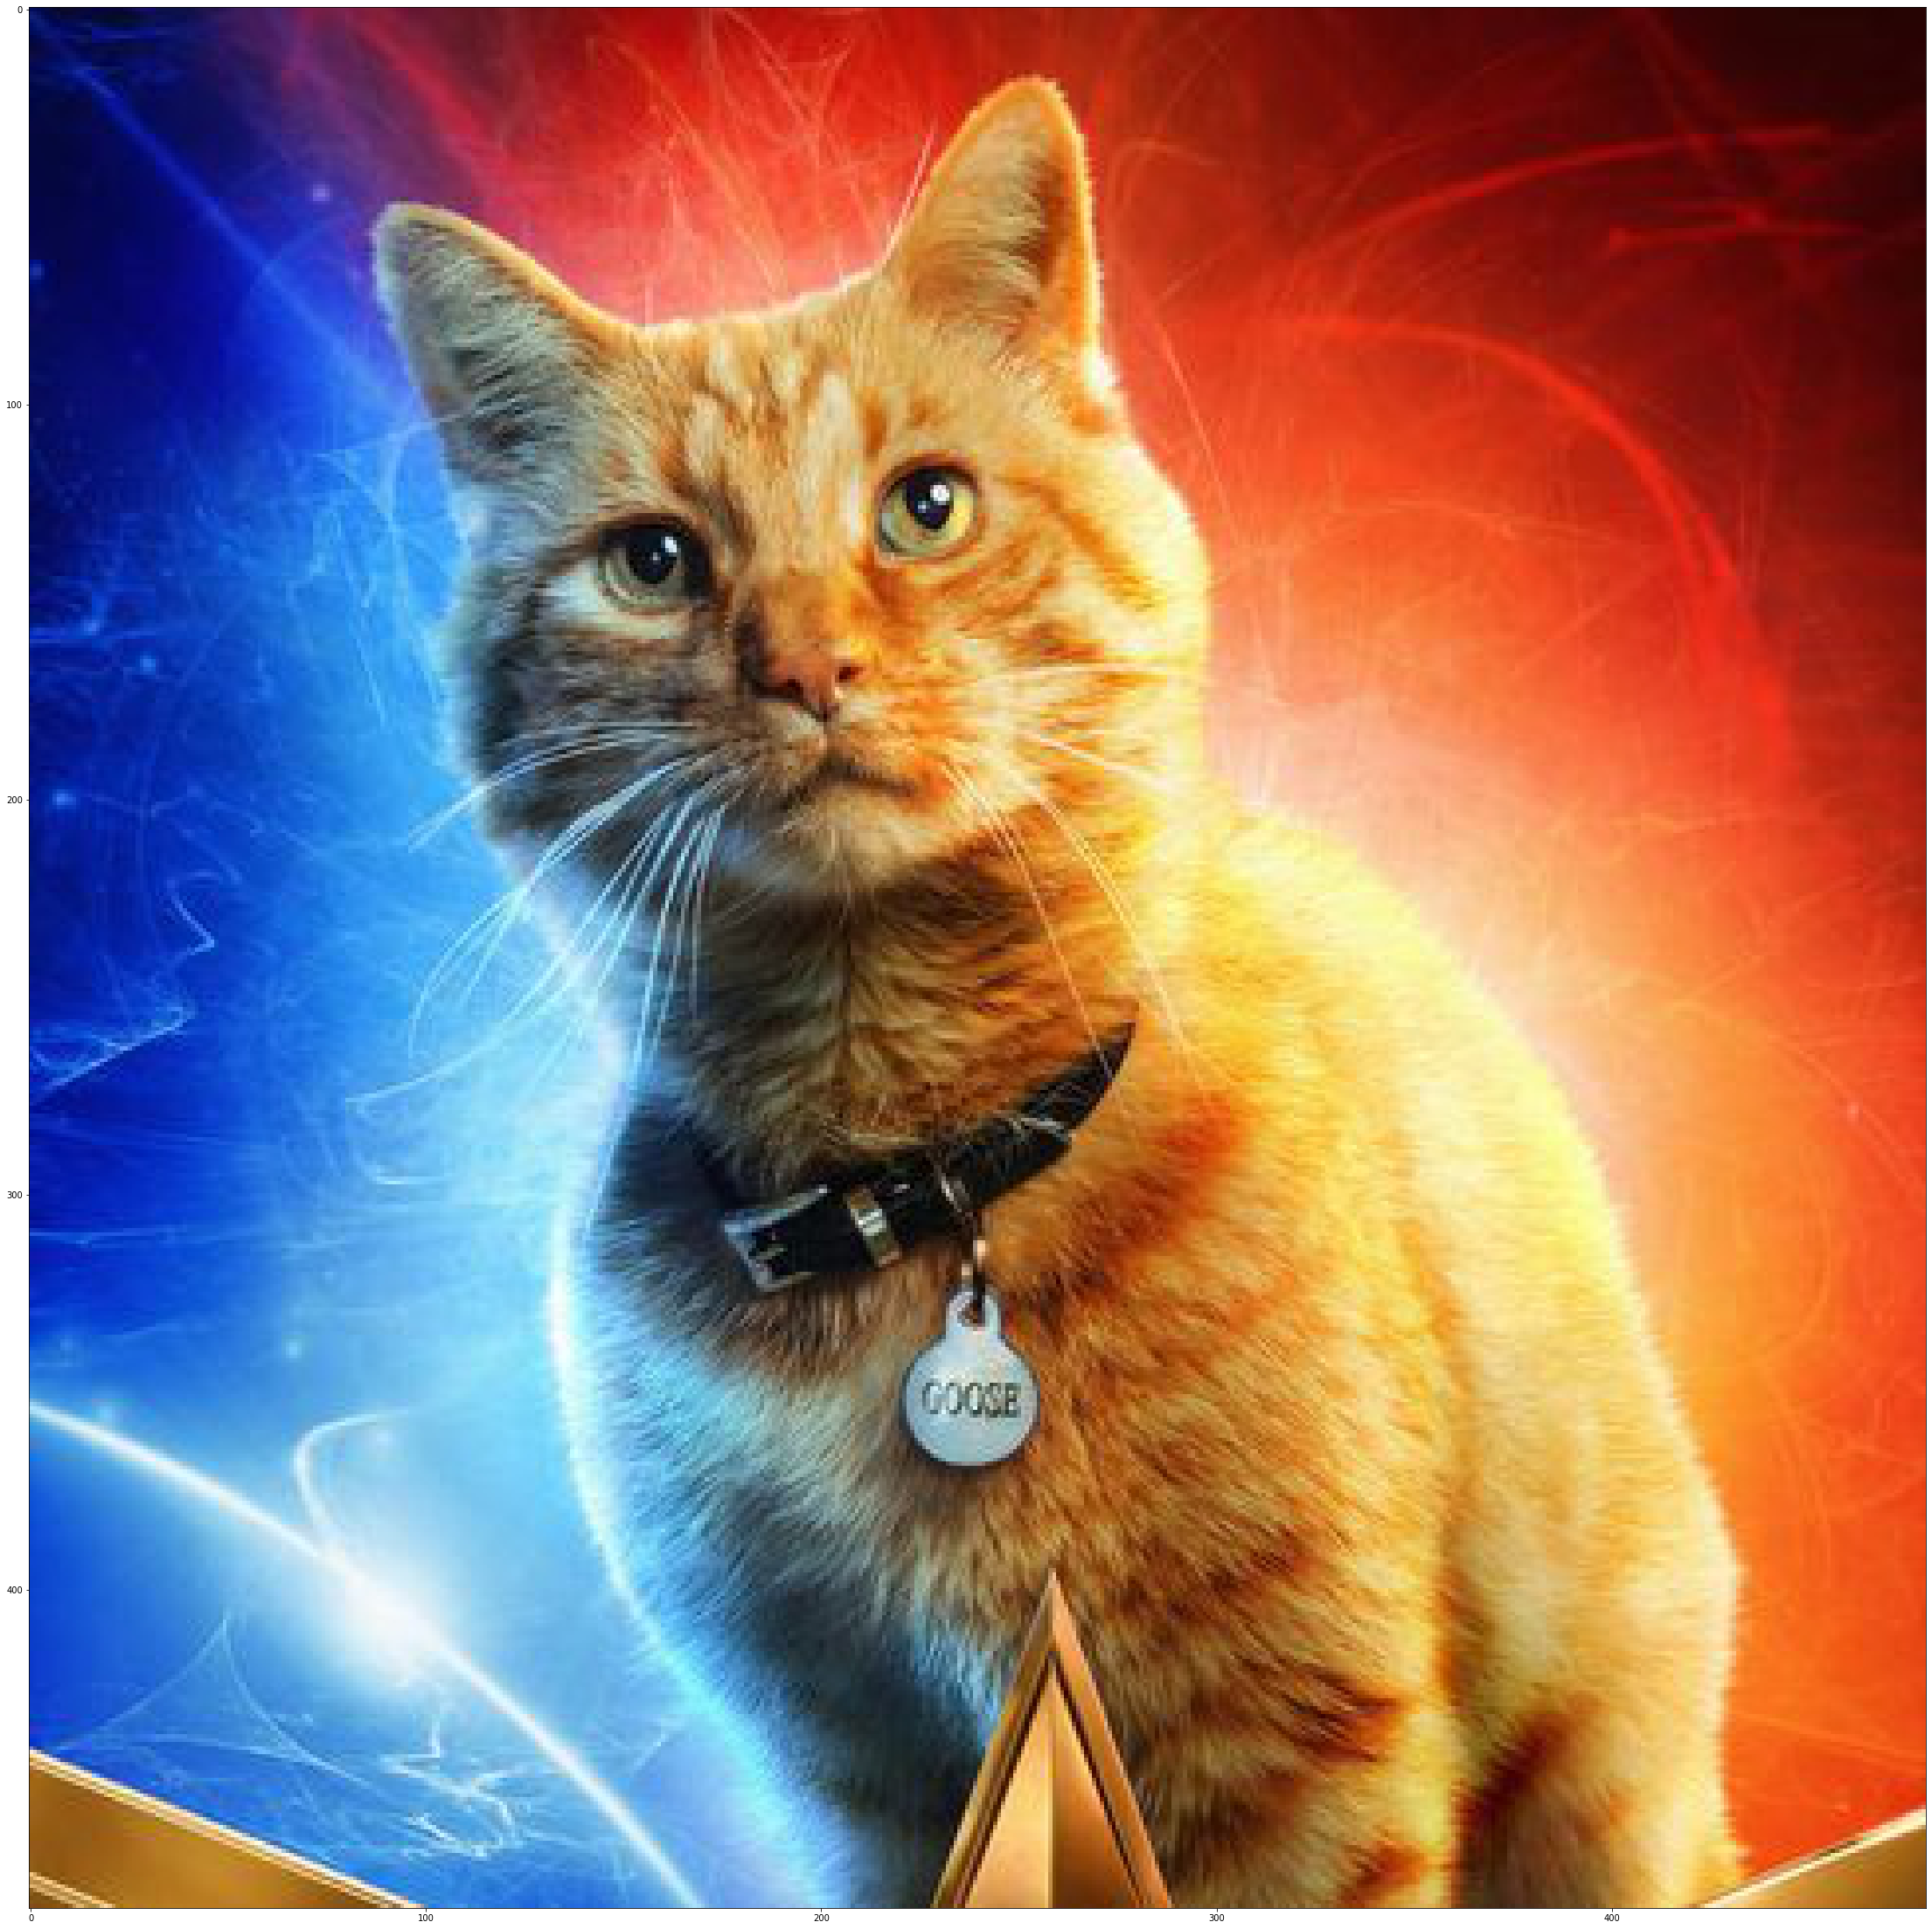

In [21]:
#Using a local image

my_image = "goose.jpg" #directory of image file
my_label_y = [1]

fname = my_image
image = np.array(imageio.imread(fname))
my_image = np.array(Image.fromarray(image).resize(size=(num_px,num_px))).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")